In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np

In [2]:
file_path = '../data/'
df = pd.read_csv(file_path+'BTC_sum_both_30s_202303271051_v1.csv')

In [82]:
print('start date: ', df['window_start'].min())
print('end date: ', df['window_end'].max())
print('shape of df:', df.shape)
print(df.columns)
df.head()

start date:  2022-12-16 21:05:30
end date:  2023-02-25 23:49:30
shape of df: (151838, 120)
Index(['window_start', 'window_end', 'num_rows', 'lowest_return',
       'highest_return', 'high_low_gap', 'trade_vol', 'volume_power',
       'beginning_price', 'ending_price',
       ...
       '%K', '%D', 'TR', '+DM', '-DM', 'ATR', '+DI', '-DI', 'DX', 'ADX'],
      dtype='object', length=120)


,window_start,window_end,num_rows,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,beginning_price,ending_price,...,%K,%D,TR,+DM,-DM,ATR,+DI,-DI,DX,ADX
0,2022-12-16 21:05:30,2022-12-16 21:06:00,14,0.000000,0.000089,0.000089,1.468656,0.747351,22568000.0,22570000.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2022-12-16 21:06:00,2022-12-16 21:06:30,10,0.000000,0.000089,0.000089,0.567585,0.027857,22568000.0,22570000.0,...,NaN,NaN,2000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2022-12-16 21:06:30,2022-12-16 21:07:00,24,-0.000576,0.000044,0.000620,1.677093,0.146635,22570000.0,22570000.0,...,NaN,NaN,14000.0,0.0,11000.0,NaN,NaN,NaN,NaN,NaN
3,2022-12-16 21:07:00,2022-12-16 21:07:30,22,-0.000044,0.000443,0.000488,2.439677,0.751995,22557000.0,22567000.0,...,NaN,NaN,14000.0,0.0,1000.0,NaN,NaN,NaN,NaN,NaN
4,2022-12-16 21:07:30,2022-12-16 21:08:00,24,-0.000443,0.000000,0.000443,2.345821,-0.915608,22565000.0,22555000.0,...,NaN,NaN,12000.0,0.0,1000.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


### 1) 이동평균

- 단순 이동평균(SMA): 각 거래일의 종가에 동일한 가중치 사용
- 지수 이동평균(EMA): 최근 데이터에 더 높은 가중치 부여

In [9]:
# 단순 이동평균(SMA)
df['sma_5m'] = df['ending_price'].rolling(window=10).mean() # 5분 이동평균
df['sma_15m'] = df['ending_price'].rolling(window=30).mean() # 15분 
df['sma_30m'] = df['ending_price'].rolling(window=60).mean() # 30분 
df['sma_1h'] = df['ending_price'].rolling(window=120).mean() # 1시간 

In [10]:
# 지수 이동평균(EMA)
df['ema_5m'] = df['ending_price'].ewm(span=10, adjust=False).mean() # 5분 이동평균
df['ema_15m'] = df['ending_price'].ewm(span=30, adjust=False).mean() # 15분
df['ema_30m'] = df['ending_price'].ewm(span=60, adjust=False).mean() # 30분
df['ema_1h'] = df['ending_price'].ewm(span=120, adjust=False).mean() # 1시간

### 2) 볼린저밴드

- 중앙선(중심선): n일간의 단순 이동 평균(SMA)
    일반적으로 20일 이동평균을 사용
- 상단 밴드(상한선): 중앙선에서 2(일반적으로)의 표준 편차를 더한 값
- 하단 밴드(하한선): 중앙선에서 2의 표준 편차를 뺀 값

In [83]:
N = 20

# 중앙선
df[f'mid_band_{N}m'] = df['ending_price'].rolling(window=N).mean() # 10분

# 상단 밴드(상한선)
df[f'up_band_{N}m'] = df[f'mid_band_{N}m'] + 2 * df['ending_price'].rolling(window=N).std()

# 하단 밴드(하한선)
df[f'low_band_{N}m'] = df[f'mid_band_{N}m'] - 2 * df['ending_price'].rolling(window=N).std()

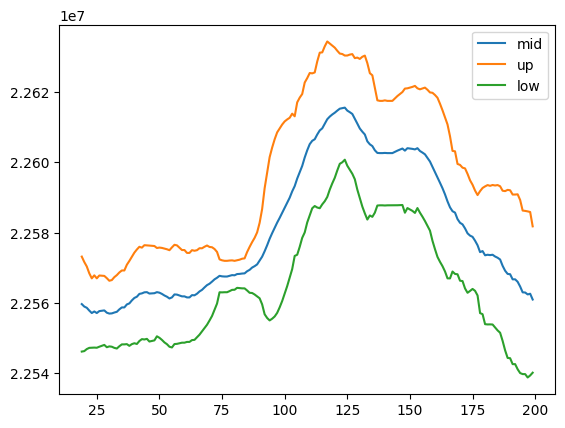

In [84]:
# 볼린저밴드 시각화

df.iloc[:200]['mid_band_20m'].plot(label='mid')
df.iloc[:200]['up_band_20m'].plot(label='up')
df.iloc[:200]['low_band_20m'].plot(label='low')
plt.legend()


### 3) 상대강도지수(Relative Strength Index, RSI)

- 가격의 상승 압력과 하락 압력 사이의 상대적 강도를 측정하여, 과매수 또는 과매도 상태를 파악하는 데 도움을 줌.
- 일반적으로 RSI 값이 70 이상이면 과매수, 30 이하면 과매도로 간주

<br>

- RSI 계산 방법
1. 일정 기간 동안의 가격 변동 계산
2. 이 가격 변동 중 상승한 날의 평균 가격 변동과 하락한 날의 평균 가격 변동을 계산
3. 상승 변동 평균을 하락 변동 평균으로 나눈 값을 상대강도(RS)로 정의
4. RSI 공식을 사용하여 계산

In [32]:
# 가격 변동 계산
df['delta'] = df['ending_price'].diff()

# 상승 분과 하락 분을 나누어 계산
df['gain'] = df['delta'].clip(lower=0) # 0보다 작은 모든 데이터 포인트는 0으로 대체
df['loss'] = df['delta'].clip(upper=0) # 0보다 큰 모든 데이터 포인트는 0으로 대체

# 평균 상승 및 평균 하락 계산 (통상적으로 14일 사용)
window_length = 14 # 본 데이터의 경우 7분
df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=1).mean()
df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=1).mean()

# RS 및 RSI 계산
df['rs_7m'] = df['avg_gain'] / df['avg_loss']
df['rsi_7m'] = 100 - (100 / (1 + df['rs']))


In [33]:
df['rsi_7m']

0                NaN
1                NaN
2                NaN
3           0.000000
4           0.000000
             ...    
151833    242.500000
151834    435.294118
151835    189.743590
151836    284.210526
151837    225.000000
Name: rsi_7m, Length: 151838, dtype: float64

### 4) MACD

- 단기지수이동평균값과 장기지수이동평균값의 차이를 이용한 지표로 두 이동평균선이 멀어지게 되면 다시 가까워지려고 하는 속성을 이용.
- 두개의 이동평균선의 차이가 제일 큰 시점을 찾아내는데 주력하는 기법
- MACD와 신호선의 교차점은 매수 또는 매도 신호로 해석될 수 있음

In [34]:
# 빠른 EMA
df['ema_6m'] = df['ending_price'].ewm(span=12, adjust=False).mean() # 6분

# 느린 EMA
df['ema_13m'] = df['ending_price'].ewm(span=26, adjust=False).mean() # 13분

# MACD 선: 빠른 EMA - 느린 EMA
df['MACD'] = df['ema_6m'] - df['ema_13m']

# 신호선: MACD의 9일 EMA
df['signal_line'] = df['MACD'].ewm(span=9, adjust=False).mean()


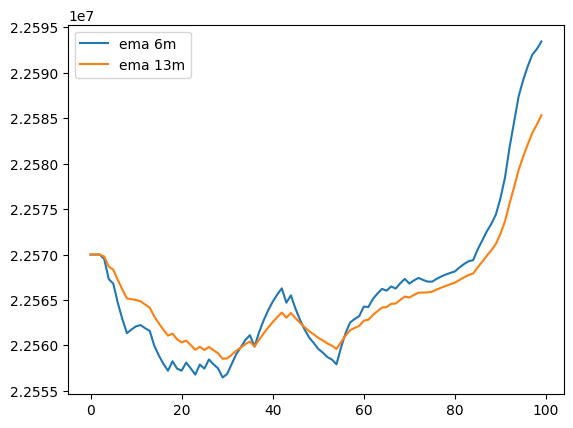

In [40]:
# 시각화
df.iloc[:100]['ema_6m'].plot(label='ema 6m')
df.iloc[:100]['ema_13m'].plot(label='ema 13m')
#df.iloc[:100]['MACD'].plot(label='macd')
#df.iloc[:100]['signal_line'].plot(label='signal_line')
plt.legend()

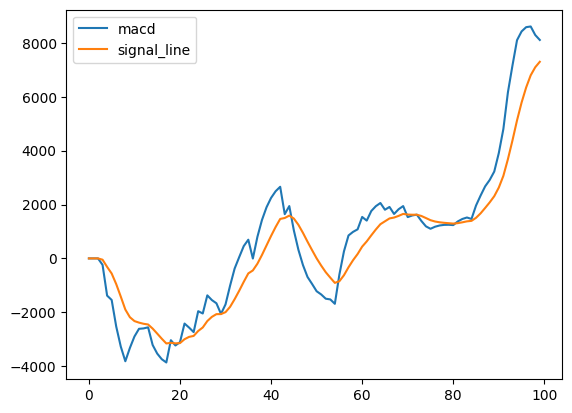

In [38]:
df.iloc[:100]['MACD'].plot(label='macd')
df.iloc[:100]['signal_line'].plot(label='signal_line')
plt.legend()

### 5) 스토캐스틱 오실레이터(Stochastic Oscillator)

- 스토캐스틱은 주식, 선물 등의 금융 시장에서 가격의 상대적 위치를 판단하기 위해 사용되는 모멘텀 보조지표.
- 이 지표는 현재 가격이 최근의 가격 범위 내에서 어디에 위치하는지를 표현함으로써 과매수나 과매도 영역을 확인하는 데 도움을 줌.
- 일정 기간 동안 최고가와 최저가 사이에서 현재의 주가 위치를 백분율로 표시함.
- 최고가에 주가가 가까워지면 지표 값은 100에 가까워지고, 최저가에 가까워지면 지표 값은 0에 가까워짐.
- 일반적으로 %K라인이 80이상이면 과매수, 20 이하면 과매도 상태로 간주

In [49]:
N = 14 # 기간, 7분

# N기간 중 최고가
df[f'High_{N}'] = df['highest_price'].rolling(window=N).max()

# N기간 중 최저가
df[f'Low_{N}'] = df['lowest_price'].rolling(window=N).min()

# %K 라인 계산
df['%K'] = (df['ending_price'] - df[f'Low_{N}']) / (df[f'High_{N}'] - df['Low_14']) * 100

# %D라인 계산 (%K 라인의 3일 이동 평균) # 1분 30초
df['%D'] = df['%K'].rolling(window=3).mean()


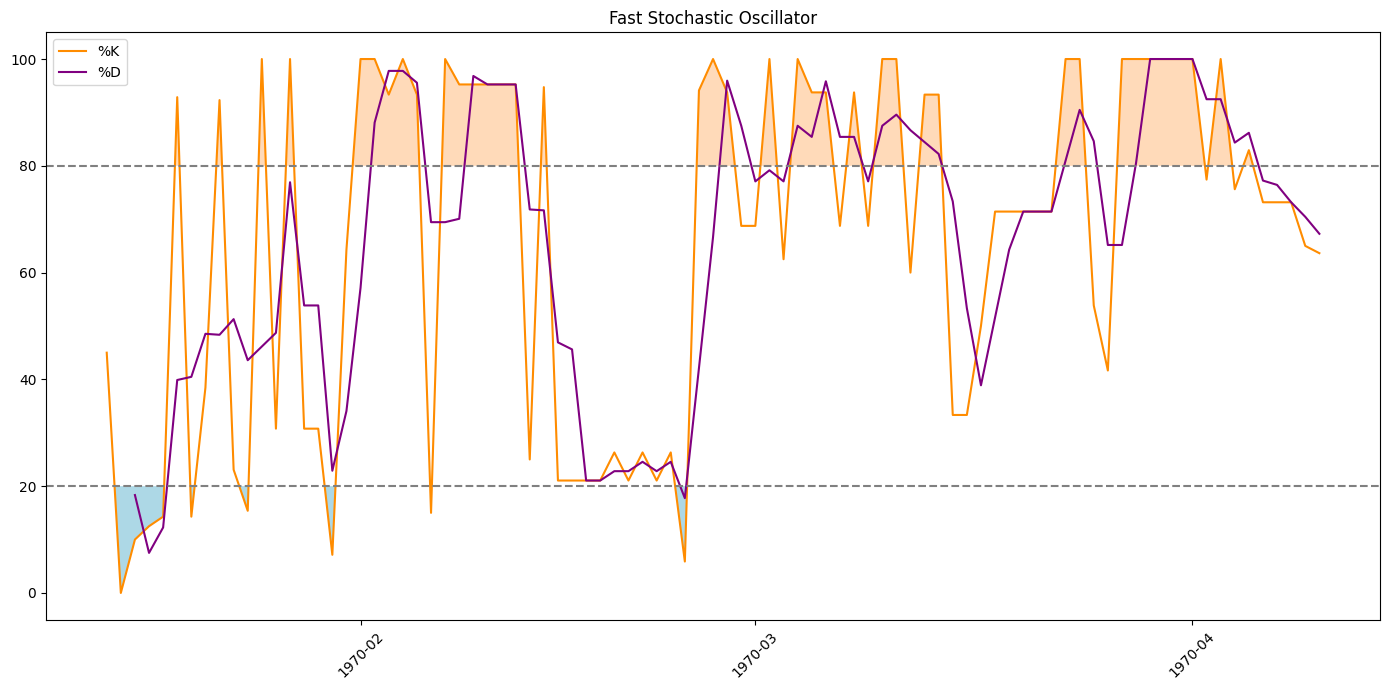

In [54]:
# 시각화

tmp_df = df.iloc[:100]

# figure 생성
fig, ax = plt.subplots(figsize=(14, 7))

# %K와 %D plot 생성
ax.plot(tmp_df['window_start'], tmp_df['%K'], color='darkorange', label='%K')
ax.plot(tmp_df['window_start'], tmp_df['%D'], color='purple', label='%D')

# 20, 80 수평선
ax.axhline(20, color='grey', linestyle='--')
ax.axhline(80, color='grey', linestyle='--')

# %K의 값이 20 이하일 떄와 80 이상일 떄의 배경색 설정
ax.fill_between(tmp_df['window_start'], tmp_df['%K'], 20, where=(tmp_df['%K'] <= 20), facecolor='lightblue', interpolate=True)
ax.fill_between(tmp_df['window_start'], tmp_df['%K'], 80, where=(tmp_df['%K'] >= 80), facecolor='peachpuff', interpolate=True)

# title, labels
ax.set_title("Fast Stochastic Oscillator")
ax.legend(loc='upper left')

# x-axis를 월단위로 변경
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### 6) 피보나치 되돌림

- 금융 시장에서 가격 움직임의 가능한 되돌림 지점을 예측하기 위해 사용되는 기술적 분석 도구.
- 이 도구는 주요 피보나치 비율은 0%, 23.6%, 38.2%, 50%, 61.8%, 100%fmf tkdyd
- 주가나 시장 지수가 최근의 상승 또는 하락 추세에서 어느 지점까지 되돌아갈 가능성이 있는지를 나타냄.
- 트레이더들은 이러한 비율을 사용하여 매수 또는 매도 지점, 그리고 손절매 또는 이익 실현 지점을 결정(지지선, 저항선)

In [60]:
def calculate_fibonacci_retracement(high, low):
    """
    최고점(high)과 최저점(low)을 기반으로 피보나치 되돌림 수준을 계산

    :param high: 최근 추세의 최고점
    :param low: 최근 추세의 최저점
    :return: 피보나치 되돌림 수준의 딕셔너리
    """
    difference = high - low
    levels = {
        '0%': high,
        '23.6%': high - difference * 0.236,
        '38.2%': high - difference * 0.382,
        '50%': high - difference * 0.5,
        '61.8%': high - difference * 0.618,
        '100%': low,
    }
    return levels

# 예시: 최근 추세에서의 최고점과 최저점
high = tmp_df['highest_price'].max()
low = tmp_df['lowest_price'].min()

# 피보나치 되돌림 수준 계산
fibonacci_levels = calculate_fibonacci_retracement(high, low)

# 결과 출력
for level, price in fibonacci_levels.items():
    print(f"{level}: {price}")


0%: 22610000.0
23.6%: 22595840.0
38.2%: 22587080.0
50%: 22580000.0
61.8%: 22572920.0
100%: 22550000.0


In [62]:
diffrence = high - low
first_level = high - diffrence * 0.236
second_level = high - diffrence * 0.382
third_level = high - diffrence * 0.5
fourth_level = high - diffrence * 0.618

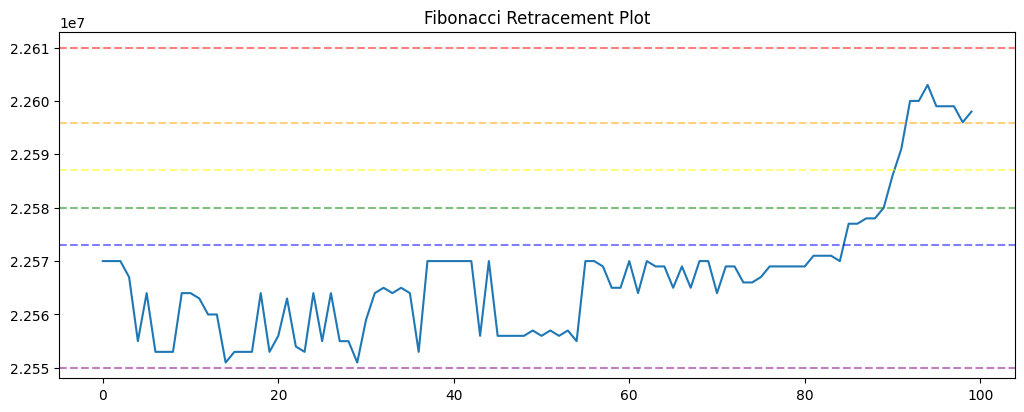

In [65]:
plt.figure(figsize=(12.33, 4.5))
plt.title('Fibonacci Retracement Plot')
plt.plot(tmp_df['ending_price'])
plt.axhline(high, linestyle='--', alpha=0.5, color='red')
plt.axhline(first_level, linestyle='--', alpha=0.5, color='orange')
plt.axhline(second_level, linestyle='--', alpha=0.5, color='yellow')
plt.axhline(third_level, linestyle='--', alpha=0.5, color='green')
plt.axhline(fourth_level, linestyle='--', alpha=0.5, color='blue')
plt.axhline(low, linestyle='--', alpha=0.5, color='purple')
plt.show()

### 7) ADX(Average Directional Index)

- 추세의 강도를 측정하는데 유용한 보조 지표
- ADX는 추세의 방향이 아닌 추세의 강도만 나타냄
- 보통 14일의 추세를 계산하기 때문에 시장의 변화가 발생한 이후에 후행적으로 변화가 나타나고 이로 인해 가격 변동이 심하면 제대로 대응하지 못할 수 있음
- 0에서 100까지의 값을 가지며 보통 20 이하의 값은 추세가 약함을, 20~40은 추세가 강함을, 40 이상은 추세가 매우 강함을 나타냄
- 추세의 강도만 나타냄으로 다른 기술적 분석 도구와 함께 사용될 때, 시장의 상황을 더욱 정확하게 평가할 수 있음

<br>

- 계산 과정
1. 방향성 지표(Directional Movement Indicators, DMI) 계산:
    +DI(Positive Directional Indicator): 현재 고가와 이전 고가의 차이를 계산하여 양의 방향성 움직임을 나타냄
    -DI(Negative Directional Indicator): 현재 저가와 이전 저가의 차이를 계산하여 음의 방향성 움직임을 나타냄
2. 방향성 움직임(Directional Movement, DM) 계산:
    양의 DM과 음의 DM을 각각 계산
3. True Range(TD) 계산:
    현재 고가와 저가의 차이, 현재 고가와 이전 종가의 차이, 현재 저가와 이전 종가의 차이 중 가장 큰 값을 선택
4. ADX 계산:
    +DI와 -DI의 절대 차이를 TR로 나눈 후, 이를 일정 기간 동안의 평균으로 계산하여 ADX를 구함

In [68]:
# True Range 계산
df['TR'] = np.maximum(df['highest_price'] - df['lowest_price'], 
                      np.maximum(abs(df['highest_price'] - df['ending_price'].shift(1)), 
                                 abs(df['lowest_price'] - df['ending_price'].shift(1))))

# +DM과 -DM 계산
df['+DM'] = np.where((df['highest_price'] - df['highest_price'].shift(1)) > (df['lowest_price'].shift(1) - df['lowest_price']), 
                     df['highest_price'] - df['highest_price'].shift(1), 0)
df['+DM'] = df['+DM'].where(df['+DM'] > 0, 0)

df['-DM'] = np.where((df['lowest_price'].shift(1) - df['lowest_price']) > (df['highest_price'] - df['highest_price'].shift(1)), 
                     df['lowest_price'].shift(1) - df['lowest_price'], 0)
df['-DM'] = df['-DM'].where(df['-DM'] > 0, 0)

# ADX 계산에 필요한 평균 TR, +DI, -DI 계산
window = 14
df['ATR'] = df['TR'].rolling(window=window).mean()
df['+DI'] = 100 * (df['+DM'].rolling(window=window).mean() / df['ATR'])
df['-DI'] = 100 * (df['-DM'].rolling(window=window).mean() / df['ATR'])

# ADX 계산
df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
df['ADX'] = df['DX'].rolling(window=window).mean()


In [71]:
df['ADX']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
151833    26.859493
151834    23.595670
151835    20.362215
151836    19.986610
151837    20.162691
Name: ADX, Length: 151838, dtype: float64